## Import Libraries

In [ ]:
from sklearn.metrics import classification_report
import pickle
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from tqdm import tqdm
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# My Class

## Process Data Class

In [ ]:
class ProcessData:
    def __init__(self):
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None

    def read_train_csv(self, train_file_path: str):
        '''
        read data from file path
        :param train_file_path: str
            path of training file
        :return: list
            Data of training set
        '''
        df_train = pd.read_csv(train_file_path)
        self.x_train = df_train['message'].to_list()[:]
        self.y_train = df_train['topic'].to_list()[:]
        return self.x_train, self.y_train

    def read_test_csv(self, test_file_path: str, labels_test_file_path: str):
        '''
        read test data from file path
        :param test_file_path: str
            path of input testing path
        :param labels_test_file_path: str
            path of output testing path
        :return: list
            Data of testing set
        '''
        df_test = pd.read_csv(test_file_path)
        df_label_test = pd.read_csv(labels_test_file_path)
        self.x_test = df_test['message'].to_list()[:]
        self.y_test = df_label_test['topic'].to_list()[:]
        return self.x_test, self.y_test



## Word Embedding Class

In [ ]:
class WordEmbedding():
    def __init__(self):
        self.stop_words = stopwords.words('english')
        self.word2vec = None
        self.all_words = None
        self.tokenizer = None
        self.mean = None
        self.std = None

    @staticmethod
    def _stemming(data: list) -> list:
        '''
        Stemming for training set
        :param data: list
            list of sentences in training set
        :return: list
            all words after stemming
        '''
        poster_stemmer = PorterStemmer()
        all_words = [[poster_stemmer.stem(word) for word in sentence] for sentence in data]
        return all_words

    def norm_data(self, x: list) -> np.ndarray:
        '''
        Normalize data with mean and std
        :param x: list
            Input data
        :return: np.ndarray
            Data after normalize
        '''
        self.mean = np.mean(x)
        self.std = np.std(x)
        return (x - self.mean) / self.std

    def norm_data_test(self, x_test: list) -> np.ndarray:
        '''
        Normalize data of test set using mean and std of training set
        :param x_test: list
            Input data
        :return: np.ndarray
            Test set after normalize
        '''
        return (x_test - self.mean) / self.std

    def _vectorized(self, data_list: list) -> list:
        '''
        tokenized for sentences in data set
        :param data_list: list
            list of data in training set
        :return: list
            all words after tokenized
        '''
        tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
        poster_stemmer = PorterStemmer()
        self.all_words = []
        for data in tqdm(data_list):
            data_tokenized = data.lower()
            data_tokenized = tokenizer.tokenize(data_tokenized)
            data_tokenized = [poster_stemmer.stem(word) for word in data_tokenized
                              if word not in self.stop_words and len(word) > 2]
            self.all_words.append(data_tokenized)
        return self.all_words

    def _word2vec(self, data_list: list):
        '''
        Word to vec for training set using gensim library
        :param data_list: list
            list of sentences in training set
        :return: None
        '''
        self.all_words = self._vectorized(data_list)
        t1 = time.time()
        self.word2vec = Word2Vec(self.all_words, min_count=5, size=300,
                                 window=30, workers=10, iter=30)
        t2 = time.time()
        print("time word2vec", t2 - t1)
        for i, data in tqdm(enumerate(self.all_words)):
            data_tokenized = [word for word in data if word in self.word2vec.wv.index2word]
            self.all_words[i] = data_tokenized

    def doc2vec(self, data_list: list) -> np.ndarray:
        '''
        transform sentences to vector using Word2Vec
        :param data_list: list
            List of sentences
        :return: np.ndarray
            Vector of all sentences in training set
        '''
        self._word2vec(data_list)
        param_vec = []
        for param in self.all_words:
            param_vec.append(np.sum(self.word2vec.wv[param], axis=0)/len(param))
        param_vec = self.norm_data(param_vec)
        return param_vec

    def fit_transform(self, x_test):
        x_test_embedded = []
        tokenizer = RegexpTokenizer(r'[a-zA-Z0-9]+')
        poster_stemmer = PorterStemmer()
        for data in tqdm(x_test):
            data_tokenized = data.lower()
            data_tokenized = tokenizer.tokenize(data_tokenized)
            data_tokenized = [poster_stemmer.stem(word) for word in data_tokenized
                              if word not in self.stop_words and len(word) > 2]
            data_tokenized = [word for word in data_tokenized if word in self.word2vec.wv.index2word]
            x_test_embedded.append(np.sum(self.word2vec.wv[data_tokenized], axis=0)/len(data_tokenized))
        x_test_embedded = self.norm_data_test(x_test_embedded)
        return x_test_embedded

## Logistic Regression Class

In [ ]:
class MyLogisticRegression():
    def __init__(self, max_iter=500, lr=0.00001):
        self.max_iter = max_iter
        self.lr = lr
        self.m = None
        self.n = None
        self.w = None
        self.num_class = None
        self.y_train_one_hot = None

    @staticmethod
    def sigmoid(z: np.ndarray) -> np.ndarray:
        '''
        sigmoid function
        :param z:
        :return: np.ndarray
        '''
        return 1/(1 + np.exp(-z))

    @staticmethod
    def one_hot(y: list, nb_class: int) -> np.ndarray:
        '''
        One hot vectors for labels
        :param y: list
            List of labels
        :param nb_class: int
            Number of class in data set
        :return:
        '''
        y = np.array(y)
        y_one_hot = np.eye(nb_class)[y]
        return y_one_hot

    @staticmethod
    def accuracy_score(y_test: list, y_pred: list) -> float:
        '''
        Calculate accuracy of model
        :param y_test: list
            Labels of test set
        :param y_pred:
            Predicted labels of model
        :return: float
            Accuracy of model
        '''
        return sum(np.equal(y_test, y_pred)) / len(y_test)

    @staticmethod
    def plot_loss(total_lost: list):
        '''
        Plot loss of training
        :param total_lost: list of history lost during training
        :return: None
        '''
        plt.figure(figsize=(15, 6))
        plt.plot(range(len(total_lost)), total_lost)
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

    def cost(self, z: np.ndarray) -> float:
        '''
        Calculate loss of each epochs
        :param z: np.ndarray
            z of model in training phase
        :return: float
            Loss of each epochs
        '''
        cost = np.sum(-1/self.m*(self.y_train_one_hot*np.log(z) + (1-self.y_train_one_hot)*np.log(1-z)))/self.num_class
        return cost

    def fit(self, x_train: np.ndarray, y_train: list) -> list:
        '''
        Fit data to training
        :param x_train: np.ndarray
            Input of training set
        :param y_train: list
            Output of training set
        :return: list
            History of loss during training
        '''
        self.m = x_train.shape[0]
        self.n = x_train.shape[1]
        self.num_class = np.max(y_train) + 1
        self.w = np.zeros((self.num_class, self.n))
        cost = np.zeros(self.max_iter)
        self.y_train_one_hot = self.one_hot(y_train, self.num_class)
        total_lost = []
        for i in tqdm(range(self.max_iter)):
            z = self.sigmoid(x_train @ self.w.T)
            cost = self.cost(z)
            self.w = self.w + self.lr*(self.y_train_one_hot - z).T @ x_train
            total_lost.append(cost)
        return total_lost

    def predict(self, x_test: np.ndarray) -> list:
        '''
        Predict labels for test set
        :param x_test: np.ndarray
            Input of test set
        :return:
            Predicted labels for test set
        '''
        z = self.sigmoid(x_test @ self.w.T)
        y_pred = list(np.argmax(z, axis=1))
        return y_pred

# Main Code

## Init variable

In [ ]:
#Initialize
train_path = "/content/drive/MyDrive/BAP Colab/LogisticRegression/train.csv"
test_path = "/content/drive/MyDrive/BAP Colab/LogisticRegression/test.csv"
labels_test_path = "/content/drive/MyDrive/BAP Colab/LogisticRegression/solution.csv"
MAX_ITER = 2500
LEARNING_RATE = 0.00001
SAVE_WORD2VEC = True
SAVE_MODEL = True

## Read Data from file

In [ ]:
process_data = ProcessData()
x_train, y_train = process_data.read_train_csv(train_path)
x_test, y_test = process_data.read_test_csv(test_path, labels_test_path)
print(x_train[0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







## Plot distribution of training set

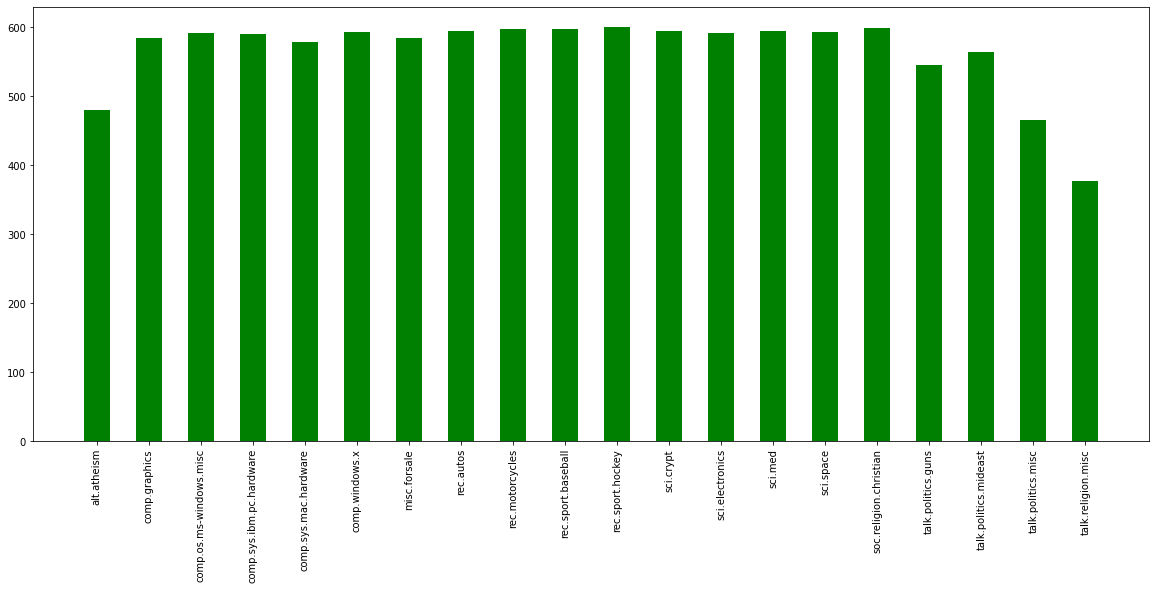

In [ ]:
labels = ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
          'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles',
          'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med',
          'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast',
          'talk.politics.misc', 'talk.religion.misc']
labels_count = np.unique(y_train, return_counts=True)
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(labels_count[0], labels_count[1], 0.5, tick_label=labels, color='green')
ax.set_xticklabels(labels, Rotation=90)
plt.show()

## Plot distribution of test set

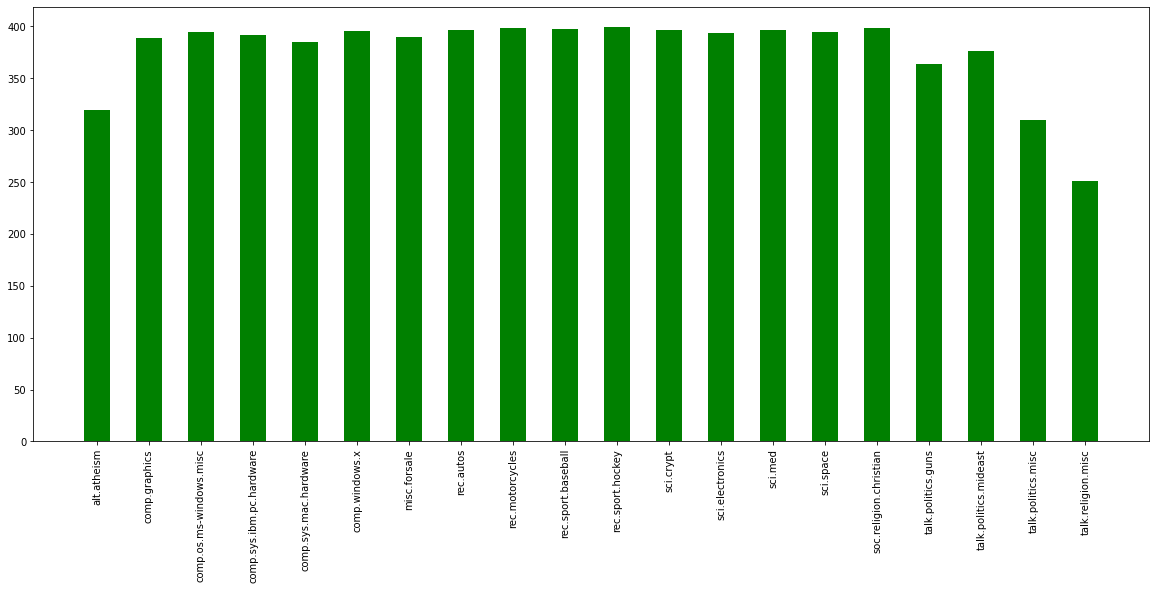

In [ ]:
labels_count = np.unique(y_test, return_counts=True)
fig, ax = plt.subplots(figsize=(20, 8))
ax.bar(labels_count[0], labels_count[1], 0.5, tick_label=labels, color='green')
ax.set_xticklabels(labels, Rotation=90)
plt.show()

## Word Embbeding using Word2Vec

We will use gensim library to implement Word2Vec for all words in our Corpus.

Typically, we have 3 ways to implement Word2Vec for sentences of paragraph:

* Average
* Weighted Count Vectorizer
* Weighted Tf-idf Vectorizer

In this project we'll take the naive approach and use an average of all the words in the document.


In [ ]:
if SAVE_WORD2VEC:
    word_embedding = WordEmbedding()
    x_train_embedded = word_embedding.doc2vec(x_train)
    x_test_embedded = word_embedding.fit_transform(x_test)
    with open("/content/drive/MyDrive/BAP Colab/LogisticRegression/all_words.pickle", "wb") as handle:
        pickle.dump([x_train_embedded, x_test_embedded], handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("save file successed!")
else:
    with open("/content/drive/MyDrive/BAP Colab/LogisticRegression/all_words.pickle", "rb") as handle:
        x_train_embedded, x_test_embedded = pickle.load(handle)

100%|██████████| 11314/11314 [00:47<00:00, 238.77it/s]
12it [00:00, 104.75it/s]

time word2vec 275.42601323127747


11314it [02:47, 67.35it/s]
100%|██████████| 7532/7532 [02:35<00:00, 48.43it/s]


save file successed!


## Create and Training model

In [ ]:
if SAVE_MODEL == True:
    clf = MyLogisticRegression(max_iter=MAX_ITER, lr=LEARNING_RATE)
    total_lost = clf.fit(x_train_embedded, y_train)
    with open("/content/drive/MyDrive/BAP Colab/LogisticRegression/model.pickle", "wb") as handle:
        pickle.dump([clf, total_lost], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("/content/drive/MyDrive/BAP Colab/LogisticRegression/model.pickle", "rb") as handle:
        clf, total_lost = pickle.load(handle)

100%|██████████| 2500/2500 [02:45<00:00, 15.07it/s]


Plot loss during training
In this project we will train model with 2500 epochs and plot the loss value after each epochs using Matplotlib library.

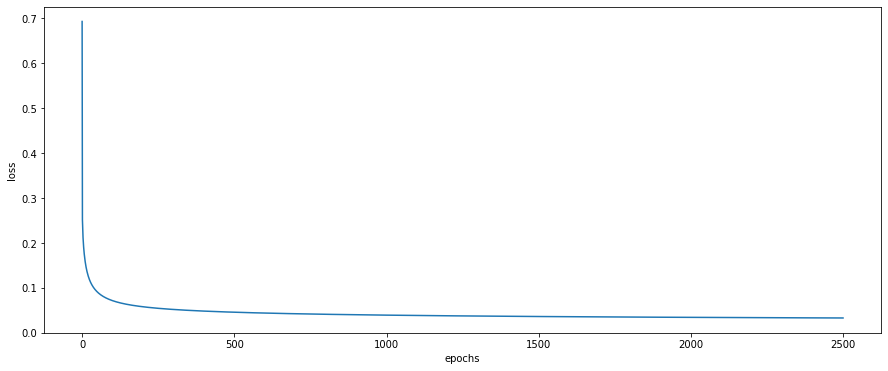

In [ ]:
clf.plot_loss(total_lost)

I tried with many difference value of hyperparameters like learning rate, number of epochs,...
We see that loss decreases after epochs and that is to be expected of machine learning models.

## Evaluation Model

Predict for training set

In [ ]:
y_pred = clf.predict(x_train_embedded)
acc = clf.accuracy_score(y_train, y_pred)
print(f'accuracy with {MAX_ITER} epochs and {LEARNING_RATE} learning rate = ', acc)

accuracy with 2500 epochs and 1e-05 learning rate =  0.9182428849213364


In [ ]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       480
           1       0.86      0.87      0.86       584
           2       0.84      0.86      0.85       591
           3       0.82      0.80      0.81       590
           4       0.88      0.88      0.88       578
           5       0.92      0.92      0.92       593
           6       0.88      0.90      0.89       585
           7       0.91      0.93      0.92       594
           8       0.96      0.96      0.96       598
           9       0.98      0.98      0.98       597
          10       0.99      0.99      0.99       600
          11       0.97      0.97      0.97       595
          12       0.88      0.83      0.86       591
          13       0.97      0.97      0.97       594
          14       0.98      0.97      0.97       593
          15       0.90      0.96      0.93       599
          16       0.94      0.96      0.95       546
          17       0.97    

Predict for testing set

In [ ]:
y_pred = clf.predict(x_test_embedded)
acc = clf.accuracy_score(y_test, y_pred)
print(f'accuracy of testing with {MAX_ITER} epochs and {LEARNING_RATE} learning rate = ', acc)

accuracy of testing with 2500 epochs and 1e-05 learning rate =  0.7896972915560276


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.70      0.72       319
           1       0.69      0.70      0.70       389
           2       0.69      0.65      0.67       394
           3       0.65      0.66      0.65       392
           4       0.73      0.77      0.75       385
           5       0.82      0.73      0.77       395
           6       0.78      0.82      0.80       390
           7       0.86      0.87      0.87       396
           8       0.94      0.90      0.92       398
           9       0.92      0.89      0.91       397
          10       0.92      0.96      0.94       399
          11       0.91      0.91      0.91       396
          12       0.66      0.67      0.66       393
          13       0.87      0.84      0.85       396
          14       0.90      0.91      0.90       394
          15       0.76      0.87      0.81       398
          16       0.70      0.86      0.77       364
          17       0.95    